In [1]:
# from torchsr.datasets import Div2K
# from torchsr.models import ninasr_b0
from utils.training_utils import (
    Siren,
    ImageFitting,
    pixel_coordinates_normalized,
    plot_image,
    list_png_files,
    load_image,
    train_siren,
)
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
import os
import itertools
import matplotlib.pyplot as plt

# Autoreload
%reload_ext autoreload
%autoreload 2

# Div2K dataset
# dataset = Div2K(root="./data", scale=2, download=False)

In [2]:
# List all PNG files in the data folder
data_folder = "data"
image_files = list_png_files(data_folder)
print(f"Available PNG files: {image_files}")

Available PNG files: ['0010.png', '0028.png', '0002.png']


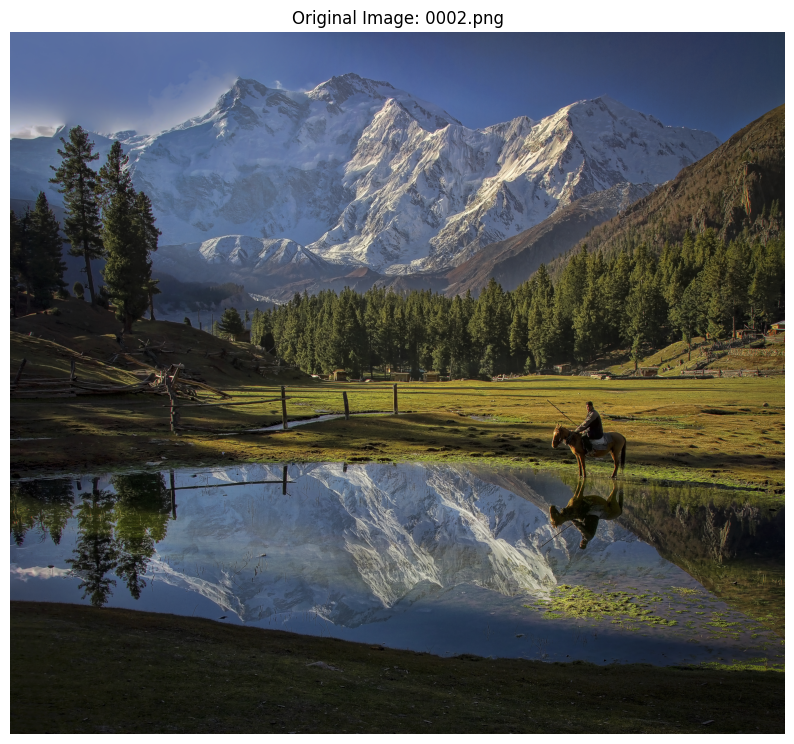

Image dimensions: 1848x2040, 3 channels


In [3]:
img_file_path = image_files[-1]
img_np_original, height_target, width_target, channels = load_image(data_folder, img_file_path)

In [4]:
# Downsample the image and generate coordinates and pixel values
downsize_factor = 3.5 # Now we can use non-integer downsize factors
(
    low_res_coords, 
    low_res_pixel_values, 
    high_res_coords, 
    high_res_pixel_values, 
    low_res_shape, 
    high_res_shape
) = pixel_coordinates_normalized(img_np_original, downsize_factor)

# Reshape the low-resolution pixel values to the image shape
low_res_image = low_res_pixel_values.reshape(low_res_shape[0], low_res_shape[1], 3)

# Plot the low-resolution image
plot_image(low_res_image, "Low-Resolution Image (Training Data)")

The original image has shape: (1848, 2040, 3)
The downsampled image has shape: (528, 582, 3)


Image dimensions: 528x582, 3 channels


In [5]:
# max and min of low_res_pixel_values
print("Low res pixel values max:", low_res_pixel_values.max())
print("Low res pixel values min:", low_res_pixel_values.min())

Low res pixel values max: 1.0
Low res pixel values min: 0.0


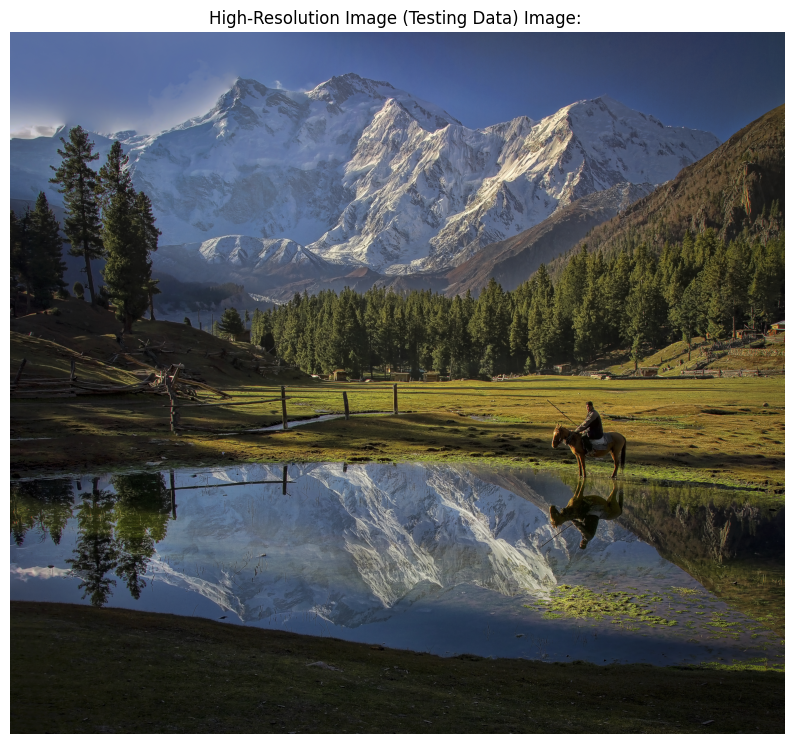

Image dimensions: 1848x2040, 3 channels


In [6]:
# Plot the original high res image

high_res_image = high_res_pixel_values.reshape(high_res_shape[0], high_res_shape[1], 3)
plot_image(high_res_image, "High-Resolution Image (Testing Data)")

In [7]:
# Initialize the model
device = torch.device(
    "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
)

print("Currently using device:", device)

Currently using device: mps


In [8]:
# Define the target resolution for the image
H, W = 256, 256  # Adjust as needed

# Create the ImageFitting dataset
dataset = ImageFitting(image_path=os.path.join(data_folder, img_file_path), H=H, W=W)

# Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

/opt/anaconda3/envs/main/lib/python3.10/site-packages/torch/functional.py:540: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
# Initialize the Siren model
model = Siren(
    in_features=2,
    hidden_features=256,
    hidden_layers=3,
    out_features=3,
    outermost_linear=True,
    first_omega_0=30,
    hidden_omega_0=30,
)

# Move the model to the appropriate device
model.to(device)

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

Step 0, Total loss 0.286041


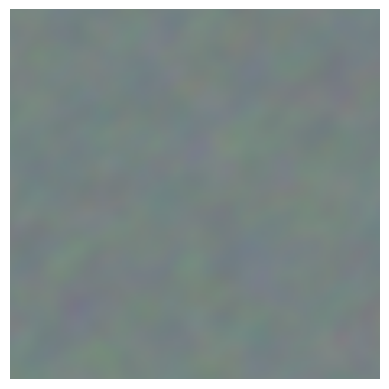

Step 250, Total loss 0.003905


Step 500, Total loss 0.001979


Step 750, Total loss 0.001107


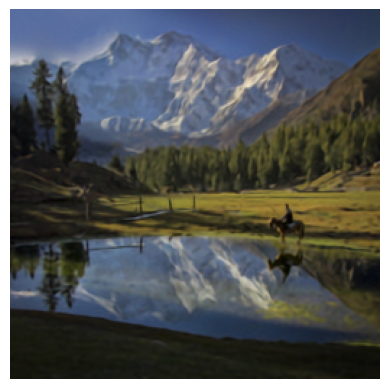

Step 1000, Total loss 0.000671


Step 1250, Total loss 0.000428


Step 1500, Total loss 0.000286


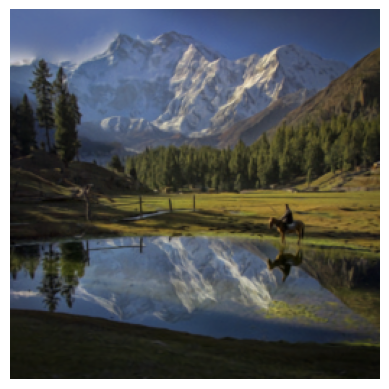

Step 1750, Total loss 0.000194


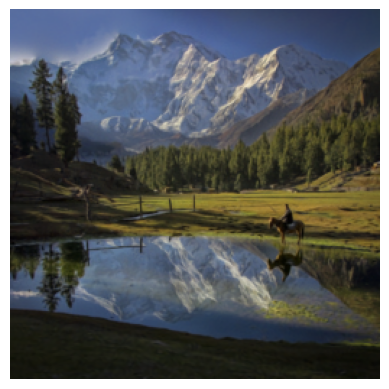

Step 2000, Total loss 0.000155


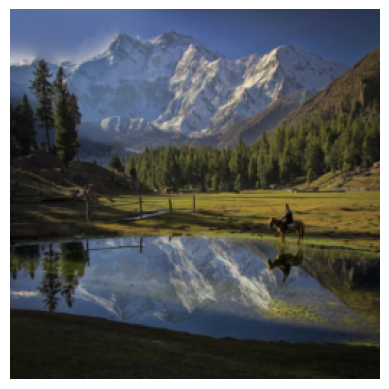

Step 2250, Total loss 0.000118


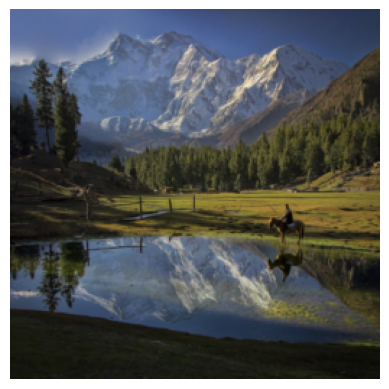

Step 2500, Total loss 0.000113


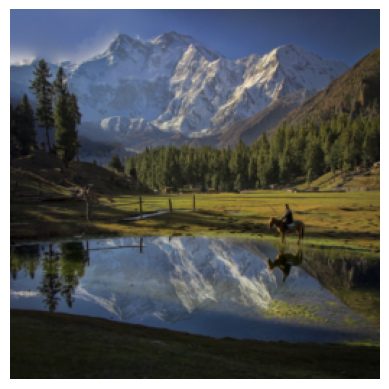

Step 2750, Total loss 0.000084


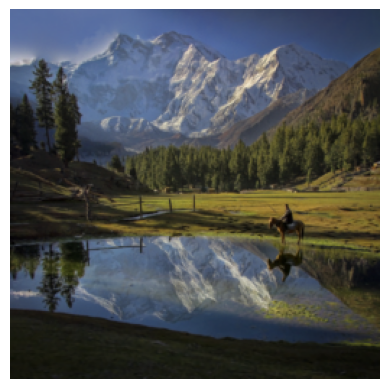

Step 3000, Total loss 0.000063


Step 3250, Total loss 0.000059


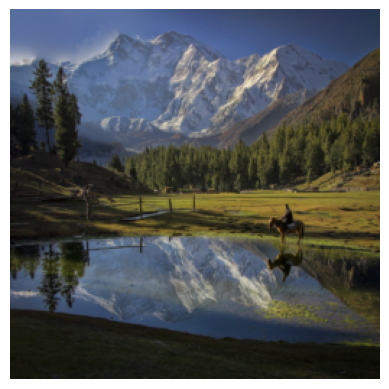

Step 3500, Total loss 0.000049


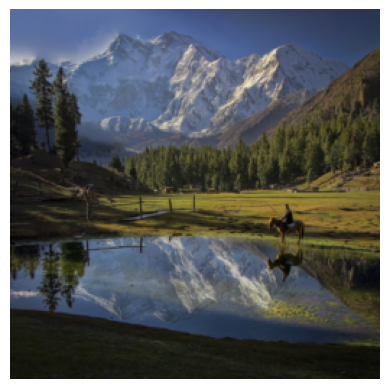

Step 3750, Total loss 0.000051


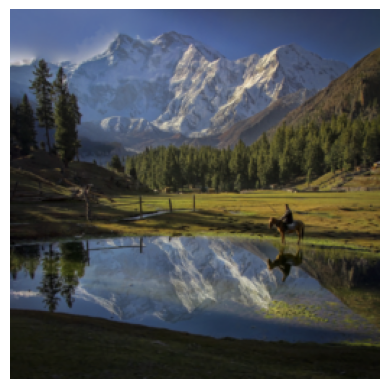

KeyboardInterrupt: 

In [13]:
# Train the model
train_siren(
    model=model,
    dataloader=dataloader,
    total_steps=5000,
    steps_til_summary=250,
    lr=1e-4,
    device=device,
    H=H,
    W=W,
)